In [1]:
import yaml
from story_sage.story_sage import StorySage
import os
import logging
import json
from story_sage.utils.local_entity_extractor import StorySageEntityExtractor

CONFIG_PATH = './config.yml'

logger = logging.getLogger()

# Load configuration and data files
with open(CONFIG_PATH, 'r') as file:
    config = yaml.safe_load(file)
with open(config['SERIES_PATH'], 'r') as file:
    series_list = yaml.safe_load(file)


api_key = config['OPENAI_API_KEY']
chroma_path = config['CHROMA_PATH']
chroma_collection = config['CHROMA_COLLECTION']

with open('./entities/entities.json', 'r') as file:
    entities = json.load(file)

# Collect series metadata names from the series list
series_metadata_names = [series['series_metadata_name'] for series in series_list]

In [14]:
from story_sage.utils.embedding import load_chunk_from_disk
import glob

def get_all_chunks(chunk_glob):
    chunks = []
    for file in glob.glob(chunk_glob):
        chunks.extend(load_chunk_from_disk(file))

    return chunks

chunks = get_all_chunks(f'./chunks/harry_potter/semantic_chunks/*.pkl')

In [71]:
series_info = next((series for series in series_list if series['series_metadata_name'] == 'harry_potter'), None)
extractor = StorySageEntityExtractor(series=series_info, device='mps')

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/chris.patten/.pyenv/versions/3.11.4/envs/story_sage_env/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [16]:
chunks

[Document(metadata={'book_number': 5, 'chapter_number': 16}, page_content='Chapter 16 In the Hog’s Head Hermione made no mention of Harry giving Defense Against the Dark Arts lessons for two whole weeks after her original suggestion. Harry’s detentions with Umbridge were finally over (he doubted whether the words now etched on the back of his hand would ever fade entirely); Ron had had four more Quidditch practices and not been shouted at during the last two; and all three of them had managed to vanish their mice in Transfiguration (Hermione had actually progressed to vanishing kittens), before the subject was broached again, on a wild, blustery evening at the end of September, when the three of them were sitting in the library, looking up potion ingredients for Snape. “I was wondering,” Hermione said suddenly, “whether you’d thought any more about Defense Against the Dark Arts, Harry.” “ ’Course I have,” said Harry grumpily. “Can’t forget it, can we, with that hag teaching us —” “I me

In [17]:
hp_entities = extractor.get_grouped_entities(documents=chunks, labels=['PERSON', 'PLACE', 'ORGANIZATION'])

Merging single-entity groups: 100%|██████████| 2166/2166 [00:00<00:00, 54973.15it/s]


In [18]:
hp_entities

In [20]:
preprocessed_entities = [name for name, id in hp_entities.get_group_ids_by_name().items()]

In [21]:
preprocessed_entities

['marchbanks',
 'professor',
 'madam',
 'snape',
 'boggart',
 'bell',
 'katie',
 'chaser',
 'brothers',
 'peverell',
 'wizard',
 'granger',
 'miss',
 'delacour',
 'fleur',
 'brown',
 'lavender',
 'elder',
 'wand',
 'brother',
 'friends',
 'human',
 'lestrange',
 'rodolphus',
 'seeker',
 'gryffindor',
 'slytherin',
 'slughorn',
 'harry',
 'lockhart',
 'gilderoy',
 'professors',
 'sprout',
 'baby',
 'dragon',
 'ariana',
 'fudge',
 'cornelius',
 'peter',
 'rowling',
 'pettigrew',
 'dolores',
 'umbridge',
 'bagshot',
 'bathilda',
 'goyle',
 'stunned',
 'ravenclaw',
 'captain',
 'davies',
 'finnigan',
 'seamus',
 'malfoy',
 'master',
 'lily',
 'evans',
 'james',
 'keeper',
 'wood',
 'gaunt',
 'merope',
 'marvolo',
 'phineas',
 'nigellus',
 'eater',
 'death',
 'vernon',
 'uncle',
 'dudley',
 'mary',
 'cattermole',
 'family',
 'riddle',
 'bones',
 'susan',
 'amelia',
 'crouch',
 'barty',
 'barry',
 'carrow',
 'alecto',
 'creevey',
 'dennis',
 'flamel',
 'nicolas',
 'bellatrix',
 'aunt',
 'pat

In [23]:
import re

def test_clean_string(text: str, 
                      names_to_skip: list[str] = [], 
                      person_titles: list[str] = [],
                      min_len: int = 3,
                      max_len: int = 30) -> str:
        
        # Add common pronouns to names_to_skip
        default_skip = ['he', 'she', 'they', 'we', 'you', 'i', 'it', 'us', 'her', 'him',
                        'child', 'sister', 'woman', 'women', 'man', 'men', 'people', 
                        'boy', 'boys', 'girl', 'girls', 'someone', 'one', 'children', 
                        'friend', 'husband', 'husbands', 'father', 'mother']
        words_to_strip = ['a', 'an', 'the', 'of']

        names_to_skip = names_to_skip + default_skip if names_to_skip else default_skip
        
        titles_pattern = r'^(?:-?)(?:' + '|'.join(person_titles) + r'\s+)|(?:\s+' + \
                        '|'.join(person_titles) + r')$'
        
        words_to_strip_pattern = r'^\s?(?:' + '|'.join(words_to_strip) + r')\s+'

        starts_to_remove_pattern = r'^[a-z]\s|-\w\s?'
        
        allowed_characters_pattern = r'[^a-z\s-]'
        
        # Remove titles using regex
        cleaned_text = re.sub(allowed_characters_pattern, '', text.strip().lower(), flags=re.IGNORECASE)
        cleaned_text = re.sub(titles_pattern, '', cleaned_text.strip(), flags=re.IGNORECASE|re.MULTILINE)
        cleaned_text = re.sub(titles_pattern, '', cleaned_text.strip(), flags=re.IGNORECASE|re.MULTILINE) # Do this twice to catch multiple titles for a person
        cleaned_text = re.sub(words_to_strip_pattern, '', cleaned_text.strip(), flags=re.IGNORECASE|re.MULTILINE)
        cleaned_text = re.sub(starts_to_remove_pattern, '', cleaned_text.strip(), flags=re.IGNORECASE|re.MULTILINE)
        cleaned_text = cleaned_text.strip()
        
        if len(cleaned_text) > min_len and len(cleaned_text) < max_len:
            if cleaned_text.startswith('of '):
                return None
            if cleaned_text in (names_to_skip + person_titles):
                return None
            if cleaned_text not in names_to_skip:
                return cleaned_text
        else:
            return None

In [49]:
# Load pre-processed entities
try:
    with open('./all_strings.json', 'r') as file:
        preprocessed_entities = json.load(file)
except Exception as e:
    logger.error(f"Error loading pre-processed entities: {e}")
    preprocessed_entities = []



In [24]:
from sklearn.cluster import DBSCAN
from story_sage.story_sage_entity import StorySageEntityCollection, StorySageEntityGroup, StorySageEntity
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

def cluster_entities(vectors, strings: list[str], eps=0.5, min_samples=2):
    # Vectorize the input strings

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    vectors = normalize(vectors, norm='l2', axis=1)

    clustering = dbscan.fit(vectors)
    labels = clustering.labels_


    # Create a dictionary to store the clusters
    clusters = {}
    for entity, label in zip(strings, labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(entity)

    # Remove the noise cluster
    noise_cluster: StorySageEntityGroup = StorySageEntityGroup(entities=[])
    if -1 in clusters:
        for entity in clusters[-1]:
            noise_cluster.add_entity(StorySageEntity(entity))
        del clusters[-1]

    clusters_list = [clusters[key] for key in clusters.keys()]

    return StorySageEntityCollection.from_sets(clusters_list), noise_cluster

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from story_sage.story_sage_entity import StorySageEntity, StorySageEntityGroup

vectorizer = TfidfVectorizer()

reclustered_groups = []

def multipass_cluster(vectors, strings, eps_first=0.5, eps_second=0.1, min_samples=2, merge_single_entities=True, verbose=False):

    def do_merge_single_entities(entities_collection: StorySageEntityCollection) -> StorySageEntityCollection:
        if verbose:
            print('---------------------------------')
            print('Merging single-entity groups with multi-entity groups')
        single_member_groups: list[StorySageEntityGroup] = [group for group in entities_collection if len(group) == 1]
        multi_member_groups: list[StorySageEntityGroup] = [group for group in entities_collection if len(group) > 1]
        multi_member_group_words = [word for group in multi_member_groups for entity in group for word in entity.entity_name.split()]

        merged_single_entities = 0
        single_entities_to_merge = 0
        unmerged_single_entities = 0
        for single_group in tqdm(single_member_groups, desc='Merging single-entity groups'):
            single_entity = single_group.entities[0]  # Get the only entity in the group
            if single_entity.entity_name not in multi_member_group_words:
                unmerged_single_entities += 1
                entities_collection.remove_entity_group(single_group.entity_group_id)
                continue
            else:
                single_entities_to_merge += 1
                
            # Look for matches in other groups
            merge_found = False
            for other_group in multi_member_groups:
                # Check if single entity matches any word in any entity in other group
                for other_entity in other_group:
                    other_entity_words = other_entity.entity_name.split()
                    if single_entity.entity_name in other_entity_words:
                        # Merge the two groups
                        other_group: StorySageEntityGroup = StorySageEntityCollection.merge_groups(other_group, single_group)
                        merge_found = True
                        merged_single_entities += 1
                        break
                if merge_found:
                    break
                # Remove the old single group
                if single_group in entities_collection:
                    entities_collection.remove_entity_group(single_group.entity_group_id)
        if verbose:
            print(f'Found {single_entities_to_merge} entities to merge')
            print(f'Merged {merged_single_entities} single-entity groups')
            print(f'Removed {unmerged_single_entities} unmergable single-entity groups')

        return entities_collection

    collected_entities, noise_cluster = cluster_entities(vectors=vectors, strings=strings, eps=eps_first, min_samples=min_samples)
    if len(collected_entities) < 1:
        raise AttributeError(f'No entities were grouped for eps_first {eps_first}, min_samples {min_samples}')
    max_group_size = max(len(group) for group in collected_entities)
    
    if verbose:
        print(f"Total entities: {len(strings)}")
        print(f"Number of groups (first clustering): {len(collected_entities)}")
        print(f"Largest group size (first clustering): {max_group_size} ({max_group_size / len(strings):.2%})")
        print(f"Noise cluster size: {len(noise_cluster)}")
    # Recluster noise_cluster
    if noise_cluster and len(noise_cluster) > 1:
        for entity in noise_cluster:
            if type(entity) == str:
                print(f'String entity: {entity}')
        entity_strings = [entity.entity_name for entity in noise_cluster]
        vectors_sub = vectorizer.fit_transform(entity_strings)
        sub_clusters, _ = cluster_entities(vectors=vectors_sub, strings=entity_strings, eps=eps_second, min_samples=1)
        for sub_cluster in sub_clusters:
            collected_entities.add_entity_group(sub_cluster)
        if verbose:
            print('---------------------------------')
            print(f"Reclustered noise cluster with eps {eps_second}: {len(sub_clusters)}")
            print(f'Multi-entity groups created: {sum([1 for group in sub_clusters if len(group) > 1])}')
            print(f'Single-entity groups created: {sum([1 for group in sub_clusters if len(group) == 1])}')

    if merge_single_entities:
        collected_entities = do_merge_single_entities(collected_entities)
        
        # Compress multi-member groups by removing multi-word entities that contain single-word entities
        multi_member_groups = []
        for group in collected_entities:
            if len(group) > 1:
                multi_member_groups.append(group)
        #multi_member_groups: list[StorySageEntityGroup] = [group for group in collected_entities if len(group) > 1]
        for group in multi_member_groups:
            # Get single word entities in this group
            single_word_entities: list[StorySageEntity] = [entity for entity in group if len(entity.entity_name.split()) == 1]
            
            # For each single word entity
            for single_entity in single_word_entities:
                # Get all multi-word entities in same group that contain this word
                to_remove = [entity for entity in group 
                            if len(entity.entity_name.split()) > 1 
                            and single_entity.entity_name in entity.entity_name.split()]
                
                # Remove matching entities from group
                for entity in to_remove:
                    group.remove_entity_by_id(entity.entity_id)

    else:
        print('---------------------------------')

    # Analyze statistics about collected entities
    total_groups = len(collected_entities)
    group_sizes = [len(group) for group in collected_entities]
    avg_group_size = sum(group_sizes) / len(group_sizes)
    median_group_size = np.median(group_sizes)
    max_group_size = max(group_sizes)
    min_group_size = min(group_sizes)
    single_entity_groups = sum(1 for size in group_sizes if size == 1)
    max_group = max(collected_entities, key=lambda x: len(x))
    if verbose:
        print(f"Total remaining groups: {total_groups}")
        print(f"Average group size: {avg_group_size:.2f}")
        print(f"Median group size: {median_group_size}")
        print(f"Largest group size: {max_group_size}")
        print(f"Smallest group size: {min_group_size}")
        print(f"Number of single-entity groups: {single_entity_groups} ({single_entity_groups / total_groups:.2%})")
        print(f"Number of multi-entity groups: {total_groups - single_entity_groups} ({(total_groups - single_entity_groups) / total_groups:.2%})")
        print('---------------------------------')
        # print the largest group
        print(f"Largest group size: {max_group_size}")
        for entity in sorted(max_group, key=lambda x: x.entity_name):
            print('    ', entity.entity_name)

        print('---------------------------------')
        print('Removing single-entity groups')
    
    # Remove single-entity groups
    for group in [group for group in collected_entities if len(group) == 1]:
        collected_entities.remove_entity_group(group.entity_group_id)

    return collected_entities

result_set = set()
for name in set(preprocessed_entities):
    result = test_clean_string(name, person_titles=series_info['entity_settings']['person_titles'])
    if result:
        result_set.add(result)

result_list = list(result_set)
vectors = vectorizer.fit_transform(result_list)
# hp first 0.5, second 0.8, min 2
# wheel of time first 0.5, second 0.8, min 2
res = multipass_cluster(vectors, result_list, eps_first=0.7, eps_second=0.5, min_samples=4, merge_single_entities=True, verbose=True)

Total entities: 5496
Number of groups (first clustering): 9
Largest group size (first clustering): 5 (0.09%)
Noise cluster size: 5459
---------------------------------
Reclustered noise cluster with eps 0.5: 5442
Multi-entity groups created: 17
Single-entity groups created: 5425
---------------------------------
Merging single-entity groups with multi-entity groups


Merging single-entity groups:   0%|          | 0/5425 [00:00<?, ?it/s]

Found 35 entities to merge
Merged 35 single-entity groups
Removed 5390 unmergable single-entity groups
Total remaining groups: 26
Average group size: 2.00
Median group size: 2.0
Largest group size: 5
Smallest group size: 1
Number of single-entity groups: 12 (46.15%)
Number of multi-entity groups: 14 (53.85%)
---------------------------------
Largest group size: 5
     kinslayer
     lews
     reborn
     telamon
     therin
---------------------------------
Removing single-entity groups


In [56]:
#Print the clusters
for entity_group in res:
    print('group:', entity_group.entity_group_id)
    for entity in entity_group:
        print('    ', entity)

group: af7cf52ac6ca4eee14f4ff9f3b28cbf5
     Entity: witches (entity)
     Entity: spies (entity)
     Entity: witch (entity)
     Entity: valon (entity)
group: 00284446a14306f8e817470690e38469
     Entity: damane (entity)
     Entity: sisters (entity)
     Entity: athaan (entity)
     Entity: miere (entity)
group: 40491e4a99b01a9c9765774f3a15b494
     Entity: therin (entity)
     Entity: lews (entity)
     Entity: telamon (entity)
     Entity: kinslayer (entity)
     Entity: reborn (entity)
group: 428ec36ffb4d9510072cd9d572750a60
     Entity: wise (entity)
     Entity: shaido (entity)
     Entity: egwene (entity)
group: 953717437b9e08e851ce0e5cf735cbc9
     Entity: far dareis (entity)
     Entity: far dareis mai (entity)
     Entity: dareis mai (entity)
     Entity: taardad (entity)
group: 2843943d910c444d44efe4890a2a883a
     Entity: elayne (entity)
     Entity: daughtereir (entity)
group: f41cde8c95170cb70a55f095fada8fe0
     Entity: bayle (entity)
     Entity: captain (entity)
    

In [57]:
with open('./entities/entities.json', 'r') as file:
    existing_entities = json.load(file)

In [58]:
existing_entities['wheel_of_time'] = res.to_dict()

In [59]:
with open('./entities/entities.json', 'w') as file:
    file.write(json.dumps(existing_entities, indent=4))

In [51]:
from story_sage.story_sage_entity import StorySageEntityCollection

with open('./entities/wheel_of_time/entities.json', 'r') as file:
    res = StorySageEntityCollection.from_json(file.read())

In [2]:
from story_sage.utils.embedding import update_tagged_entities, Embedder
import chromadb

chroma_client = chromadb.PersistentClient(path=config['CHROMA_PATH'])
embedder = Embedder()
vector_store = chroma_client.get_collection(config['CHROMA_COLLECTION'], embedding_function=embedder)

In [3]:
vector_store.get('2_1_1_0')

{'ids': [],
 'embeddings': None,
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [73]:
series_obj = next(series for series in series_list if series['series_metadata_name'] == 'harry_potter')

In [ ]:
update_tagged_entities(vector_store=vector_store, entity_collection=res, 
                       series_id=series_obj['series_id'])

In [83]:
series_list

[{'series_id': 2,
  'series_name': 'Harry Potter',
  'series_metadata_name': 'harry_potter',
  'books': [{'number_in_series': 1,
    'title': "Harry Potter and the Sorcerer's Stone",
    'book_metadata_name': '01_the_sourcerers_stone',
    'number_of_chapters': 17},
   {'number_in_series': 2,
    'title': 'Harry Potter and the Chamber of Secrets',
    'book_metadata_name': '02_the_chamber_of_secrets',
    'number_of_chapters': 18},
   {'number_in_series': 3,
    'title': 'Harry Potter and the Prisoner of Azkaban',
    'book_metadata_name': '03_the_prisoner_of_azkaban',
    'number_of_chapters': 22},
   {'number_in_series': 4,
    'title': 'Harry Potter and the Goblet of Fire',
    'book_metadata_name': '04_the_goblet_of_fire',
    'number_of_chapters': 37},
   {'number_in_series': 5,
    'title': 'Harry Potter and the Order of the Phoenix',
    'book_metadata_name': '05_the_order_of_the_phoenix',
    'number_of_chapters': 38},
   {'number_in_series': 6,
    'title': 'Harry Potter and t

In [4]:
story_sage = StorySage(
    api_key=api_key,
    chroma_path=chroma_path,
    chroma_collection_name=chroma_collection,
    entities_dict=entities,
    series_list=series_list,
    n_chunks=10  # Number of text chunks to process
)

2024-12-30 22:01:38,651 - story_sage.story_sage - DEBUG - Logger initialized from parent.


In [7]:
import logging

data = {
    'question': "what do you know about harry?",
    'book_number': 9,
    'chapter_number': 99,
    'series_id': 2
}

logging.getLogger().setLevel(logging.ERROR)
result, context, request_id = story_sage.invoke(**data)

2024-12-30 22:02:07,004 - story_sage.story_sage - INFO - Processing question: what do you know about harry? [Request ID: 94518f5d-c724-44ba-9010-ef6607c96b91]
2024-12-30 22:02:07,005 - story_sage.story_sage - DEBUG - Set request_id to 5112bb19-e33b-4318-b970-08f207079318 [Request ID: 5112bb19-e33b-4318-b970-08f207079318]
2024-12-30 22:02:07,013 - story_sage.story_sage - DEBUG - Extracting characters from question. [Request ID: 5112bb19-e33b-4318-b970-08f207079318]
2024-12-30 22:02:07,014 - story_sage.story_sage - DEBUG - Series ID found in state. [Request ID: 5112bb19-e33b-4318-b970-08f207079318]
2024-12-30 22:02:07,014 - story_sage.story_sage - DEBUG - Found entities: {'5aeed9a008d2364917615f49cd085e52'} [Request ID: 5112bb19-e33b-4318-b970-08f207079318]
2024-12-30 22:02:07,015 - story_sage.story_sage - DEBUG - Retrieving context based on the question and entities. [Request ID: 5112bb19-e33b-4318-b970-08f207079318]
2024-12-30 22:02:07,015 - story_sage.story_sage - DEBUG - order by: mo

ValueError: too many values to unpack (expected 3)

In [16]:
from pprint import pprint

pprint(context)

['Book 8, Chapter 11: Sevanna smiled. That one’s father had called himself the '
 'lord of this place and blustered that she and her people would be hunted '
 'down—by children, of all things!—for this outrage, yet now he wore white and '
 'worked as hard as his son, as did his wife and his daughters and his other '
 'sons. The women had possessed many fine gems and beautiful silks, and '
 'Sevanna had only taken the first pick for herself. A fat land, so soft it '
 'oozed rich oils. The women behind her had stopped short to talk among '
 'themselves at the edge of the trees. She caught what they were saying, and '
 'it turned her mood again. “.',
 'Book 7, Chapter 40: . . take charge of her. That tasted bitter, yet anything '
 'was better than Therava. Sevanna was ambitious, and greedy. In the midst of '
 'frowning at Galina, she had caught sight of her own hand and directed a '
 'brief, admiring smile at rings set with large emeralds and firedrops. She '
 'wore rings on half her fing

In [49]:


where_document_data = {
    '$contains': 'damane'
}

where_filter = {
    'series_id': 3
}

results = vector_store.get(where_document=where_document_data, where=where_filter, include=['metadatas'], limit=1)

In [50]:
pprint(results)

{'data': None,
 'documents': None,
 'embeddings': None,
 'ids': ['3_9_16_4'],
 'included': [<IncludeEnum.metadatas: 'metadatas'>],
 'metadatas': [{'06b002a50ace753769a46d162d63fc55': True,
                '0ca28891ce42eca5f1225c3f0acf4834': True,
                '0dfbfcfbec968bfb083f74c2d7109df0': True,
                '23f687df5466053dd89d514b23400e03': True,
                '30384d9ab569305b22c57f72c0372b39': True,
                '3_e_102': True,
                '3_e_11': True,
                '3_e_111': True,
                '3_e_123': True,
                '3_e_124': True,
                '3_e_127': True,
                '3_e_13': True,
                '3_e_139': True,
                '3_e_15': True,
                '3_e_153': True,
                '3_e_155': True,
                '3_e_157': True,
                '3_e_164': True,
                '3_e_166': True,
                '3_e_169': True,
                '3_e_172': True,
                '3_e_177': True,
                '3_e_

In [45]:
existing_count = vector_store.count()
batch_size = 1000
small_chunks = []
large_chunks = []
doc_lens = []
docs_to_update = []

def update_metadata(metadata: dict):
    return {k: v for k, v in metadata.items() if not k.startswith('3_')}


for i in range(0, existing_count, batch_size):
    batch = vector_store.get(
        include=["metadatas", "documents"],
        where={'series_id': 3},
        limit=batch_size,
        offset=i)
    if len(batch["ids"]) == 0 or len(batch["metadatas"]) == 0:
        break
    vector_store.update(ids=batch["ids"], metadatas=[update_metadata(metadata) for metadata in batch["metadatas"]])


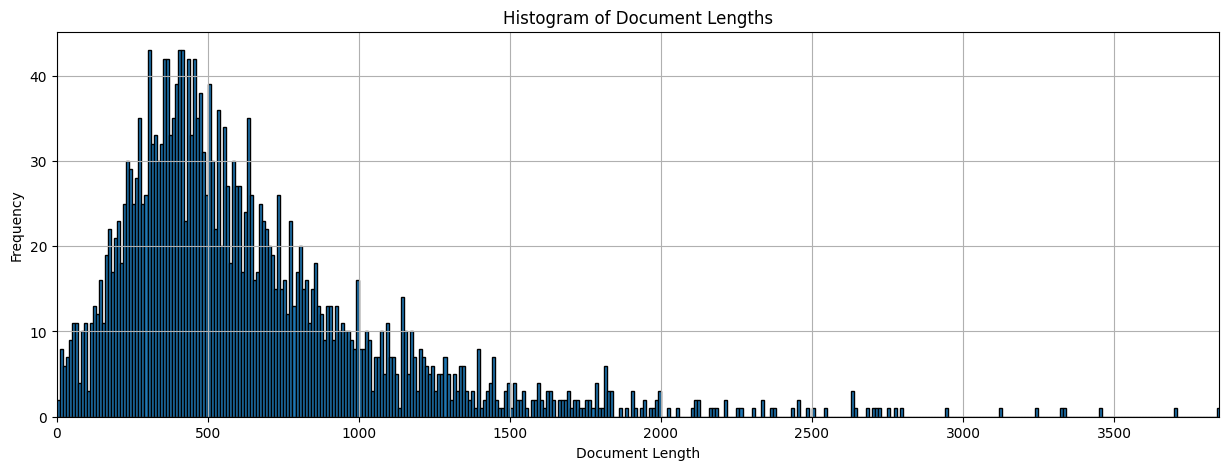

In [69]:
import matplotlib.pyplot as plt

chunk_path = './chunks/wheel_of_time/semantic_chunks/*.json'
chunks = []
for file in glob.glob(chunk_path):
    chunks.extend(load_chunk_from_disk(file))

doc_lens = [len(chunk.page_content) for chunk in chunks]

def plot_doc_lengths(doc_lens, max_length=None, bin_size=10):
    if max_length is None:
        max_length = max(doc_lens)
    
    plt.figure(figsize=(15,5))
    plt.hist(doc_lens, bins=range(0, max_length+bin_size, bin_size), edgecolor='black')
    plt.title('Histogram of Document Lengths')
    plt.xlabel('Document Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.xlim(0, max_length)

# Example usage:
plot_doc_lengths(doc_lens, max_length=None)  # Show distribution up to length 1000